# Galaxy and Non-Galaxy Classifiers:

This code contains the following two models:

- Two classifier models, including support vector machine (SVM) and classic 1D-convolutional neural network (1D-CNN), have been designed to use the Zernike moments (ZMs) extracted from the original galaxy and non-galaxy images.


This code is using code from the paper Galaxy Morphological Classification with Zernike Moments and Machine Learning Approaches by Ghaderi et al.

We will try to improve these codes by adaptions to the architecture and hyperparameter tuning. Every model is introduced by a heading stating the model name, adaptions made are given below the heading: "trial improvement" for that specific code.

This will be the structure: First the original code and than trial for improvements in big. And then onto the next model.

From each of the results the ROC curve is plotted, some metric values and the test accuracy and train accuracy.


### Import libraries:

The list of requried libraries are sklearn, pandas, numpy, tensorflow, matplotlib, etc.

In [ ]:
#Import packages

import os
from sklearn.svm import SVC
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import (Dense, Dropout,BatchNormalization, Input, Conv1D, Flatten,
                             MaxPooling1D)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


#Scikit_learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)

## Two classifier models based on Zernike moments (ZMs):

### Compute the ZMs:

##### First we need to compute ZMs for galaxy and non-galaxy images. The ZEMO python package [https://pypi.org/project/ZEMO/] [https://github.com/hmddev1/ZEMO] can be used to compute Zernike moments (ZMs) for images. This package was described in the research paper [[IAJJ](https://ijaa.du.ac.ir/article_374_ad45803d737b0a7d4fc554a244229df6.pdf)].

*Note: The galaxy and non-galaxy images are in RGB format. Here, we used the R channel of images. The size of original Galaxy Zoo 2 images is (424, 424) pixels, while we resized them to (200, 200) pixels. To compute ZMs we set the maximum order number $P{max} = 45$.*

In [ ]:
!pip install ZEMO

In [ ]:
from ZEMO import zemo
import cv2
from tqdm import tqdm  # Import tqdm for progress tracking

def calculate_zernike_moments(data_dir, image_size, zernike_order):

        ZBFSTR = zemo.zernike_bf(image_size, zernike_order, 1)

        image_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        zernike_moments = []

        #for img_path in image_files:
        for img_path in tqdm(image_files, desc="Processing images", unit="image"):

            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, (image_size,image_size))
            im = resized_image[:, :, 0]
            Z = np.abs(zemo.zernike_mom(np.array(im), ZBFSTR))
            zernike_moments.append(Z)

        df = pd.DataFrame(zernike_moments)

        return df

- Please download the **Data** files from [this link](https://drive.google.com/file/d/1wxmYQ8qpgaVDuD3kTeBrZlyny0IBA9wn/view?usp=drive_link)

- The directoies of galaxy and non-galaxy images:

        - Galaxy: /repository/Data/galaxy_nongalaxy/image/galaxy
        - Non-Galxy: /repository/Data/galaxy_nongalaxy/image/nongalaxy

In [ ]:
#!cd '/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy' && ls

In [ ]:
#!cd '/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images' && ls

In [ ]:
data_path = r'/content/drive/Shared drives/DLP Project/Project/Data/'
nongalaxy_path = os.path.join(data_path, r'galaxy_nongalaxy/images/nongalaxy')
galaxy_path = os.path.join(data_path, r'galaxy_nongalaxy/images/galaxy')

# Default image size and zernike order.
image_size = 200
zernike_order = 45


*Note: Computing of ZMs for above mentioned galaxy and non-galaxy images are slightly time consuming. So, we upladed the zernike moments of both classes in this repository.*

**To load the ZMs please use:**


In [ ]:
galaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/galaxy_zms.csv')
nongalaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/nongalaxy_zms.csv')

galaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)
nongalaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)

zmg = np.array(galaxy_zm)
zmng = np.array(nongalaxy_zm)

all_zm_data = np.concatenate([zmg,zmng])
len(zmg), len(zmng), len(all_zm_data)

(780, 555, 1335)

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxies_labels = np.zeros(len(zmg))
nongalaxy_labels = np.ones(len(zmng))
all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])
len(all_labels)

1335

### **SVM + ZMs**

- We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)


- Since, the galaxy and non-galaxy classifiers are unbalance class models, so we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}


- The **SVM** model uses radial base kernel (rbf), C = 1.5, and gamma = 'scale' to fit the model on the training set:

In [ ]:
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

- Now, we apply the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

In [ ]:
y_pred = model.predict(X_test)

con = metrics.confusion_matrix(y_test, y_pred)
print(con)

[[153  37]
 [ 15 129]]


- To compare the performace of classifier with the random classifier, we calculate the **reciver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

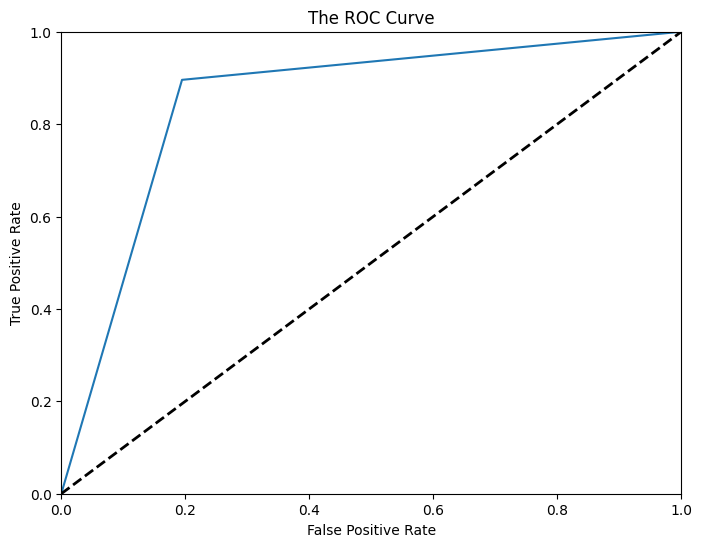

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

- To measure the performance metrics of classifier, we compute **(Recall, Precision, f1_score, Accuracy, TSS(True Skill Statistic))**

In [ ]:
recall = recall_score(y_test, y_pred, average= 'weighted')
precision = precision_score(y_test, y_pred, average= 'weighted')
#f1_score = f1_score(y_test, y_pred, average= 'weighted')
f1 = f1_score(y_test, y_pred, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.844311377245509
Precision: 0.8531117627052264
F1_score: 0.8450520836143537
Accuracy: 0.844311377245509
TSS: 0.7010964912280702
AUC: 0.8505482456140352


# Trying to improve the model:

There are a set of adaptions made in order to optimize the model. For the first model SVM with Zernike Moments SMOTE (Synthetic Minority Over-Sampling Technique)  was included to improve the imbalance in the datasets. Using a sampling strategy of 0.9 in the second trial of improvement, thus the minority class was resampled to 90\% of the majority size. The remaining imbalances were balanced using class weights. The original code only applies class weights to compensate for the imbalanced data. Smote generates synthetic samples for the minority class before training, this balances the dataset at the features level, giving the model more training samples and possibly improving the recall.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Trial2 Only adding smote, removing randomforest

[[149  50]
 [ 20 115]]


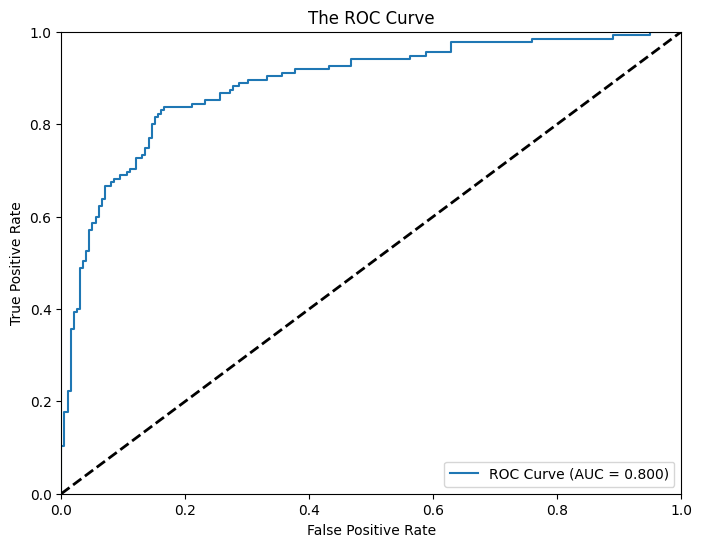

Confusion Matrix:
 [[149  50]
 [ 20 115]]
Recall: 0.852, Precision: 0.697, F1-Score: 0.767, Accuracy: 0.790, TSS: 0.601


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Split data into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    all_zm_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None
)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights dynamically
class_weights = {0: len(all_zm_data) / (2 * len(zmg)), 1: len(all_zm_data) / (2 * len(zmng))}

# Train an SVM model
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale', class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
con = metrics.confusion_matrix(y_test, y_pred)
print(con)

# Compute ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])  # Use predict_proba for ROC
auc = metrics.roc_auc_score(y_test, y_pred)

# Define class names
class_names = ['Galaxy', 'None-Galaxy']

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.legend(loc="lower right")
plt.show()




# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}, TSS: {tss:.3f}")



In [ ]:
# Compute test accuracy
test_accuracy = model.score(X_test, y_test)

# Compute a proxy for test loss using log loss (negative log likelihood)
test_loss = metrics.log_loss(y_test, model.predict_proba(X_test))

# Compute training accuracy
train_accuracy = model.score(X_train, y_train)

# Compute training loss
train_loss = metrics.log_loss(y_train, model.predict_proba(X_train))

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

Training Loss: 0.267, Training Accuracy: 0.896
Test Loss: 0.425, Test Accuracy: 0.790


# The following one is also only using smote as extra but with the sampling strategy at 0.9 instead of auto. This reduces the overfitting.

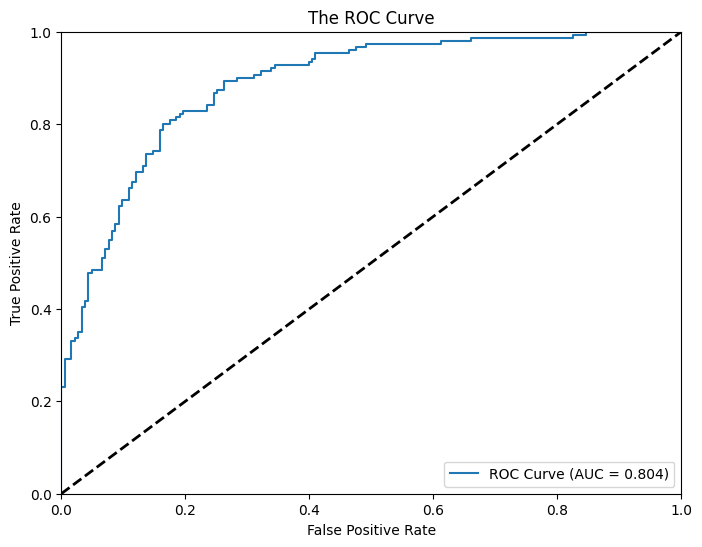

[[138  45]
 [ 22 129]]
Confusion Matrix:
 [[138  45]
 [ 22 129]]
Recall: 0.854, Precision: 0.741, F1-Score: 0.794, Accuracy: 0.799, TSS: 0.608


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Split data into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    all_zm_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None
)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)  # Ensure SMOTE is applied correctly

# Compute class weights dynamically
class_weights = {0: len(all_zm_data) / (2 * len(zmg)), 1: len(all_zm_data) / (2 * len(zmng))}

# Train an SVM model
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale', class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
con = metrics.confusion_matrix(y_test, y_pred)

# Compute ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])  # Use predict_proba for ROC
auc = metrics.roc_auc_score(y_test, y_pred)

# Define class names
class_names = ['Galaxy', 'None-Galaxy']

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print confusion matrix
print(con)


# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}, TSS: {tss:.3f}")



In [ ]:
# Compute test accuracy
test_accuracy = model.score(X_test, y_test)

# Compute a proxy for test loss using log loss (negative log likelihood)
test_loss = metrics.log_loss(y_test, model.predict_proba(X_test))

# Compute training accuracy
train_accuracy = model.score(X_train, y_train)

# Compute training loss
train_loss = metrics.log_loss(y_train, model.predict_proba(X_train))

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

Training Loss: 0.273, Training Accuracy: 0.899
Test Loss: 0.422, Test Accuracy: 0.799


Changing rbf to linear, gives a terrible accuracy and curve, only resulting in random. Thus rbf should not be changed.

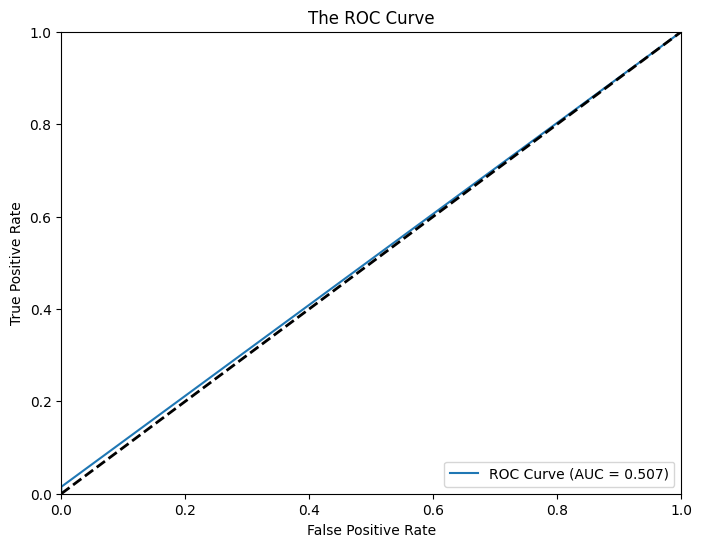

[[200   0]
 [132   2]]
Confusion Matrix:
 [[200   0]
 [132   2]]
Recall: 0.015, Precision: 1.000, F1-Score: 0.029, Accuracy: 0.605, TSS: 0.015


In [ ]:
# lower hyperparaminstead of scale

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Split data into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    all_zm_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None
)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)  # Ensure SMOTE is applied correctly

# Compute class weights dynamically
class_weights = {0: len(all_zm_data) / (2 * len(zmg)), 1: len(all_zm_data) / (2 * len(zmng))}

# Train an SVM model
model = SVC(kernel='rbf', probability=True, C=1.5, gamma=0.1, class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
con = metrics.confusion_matrix(y_test, y_pred)

# Compute ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])  # Use predict_proba for ROC
auc = metrics.roc_auc_score(y_test, y_pred)

# Define class names
class_names = ['Galaxy', 'None-Galaxy']

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print confusion matrix
print(con)


# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}, TSS: {tss:.3f}")





In [ ]:
# Compute test accuracy
test_accuracy = model.score(X_test, y_test)

# Compute a proxy for test loss using log loss (negative log likelihood)
test_loss = metrics.log_loss(y_test, model.predict_proba(X_test))

# Compute training accuracy
train_accuracy = model.score(X_train, y_train)

# Compute training loss
train_loss = metrics.log_loss(y_train, model.predict_proba(X_train))

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

Training Loss: 0.041, Training Accuracy: 1.000
Test Loss: 0.678, Test Accuracy: 0.605


### **1D_CNN + ZMs**

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxies_labels = np.zeros(len(zmg))
nongalaxy_labels = np.ones(len(zmng))
all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])
len(all_labels)

1335

- We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

- Since, the galaxy and non-galaxy classifiers are unbalance class models, so we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

- Due to one dimentional structure of ZMs, we used one dimentional achitecture of CNN:

In [ ]:
# input value
x = Input(shape=(all_zm_data.shape[1],1))

#hidden layers
c0 = Conv1D(256, kernel_size=3, strides=2, padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling1D(pool_size=2)(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv1D(128, kernel_size=3, strides=2, padding="same")(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling1D(pool_size=2)(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv1D(64, kernel_size=3, strides=2, padding="same")(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling1D(pool_size=2)(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(d2)

# output
de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(2, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_zm_45_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_zm_45_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_84 (Conv1D)                   │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_84               │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_84 (MaxPooling1D)      │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_85 (Conv1D)                   │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_85               │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_85 (MaxPooling1D)      │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_86 (Conv1D)                   │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_86               │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_86 (MaxPooling1D)      │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,730 (772.38 KB)

 Trainable params: 196,834 (768.88 KB)

 Non-trainable params: 896 (3.50 KB)

- The **1D_CNN** model uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Getting the initial weights of the model
# in case we need to reset it later - Issa
initial_weights = model.get_weights()

In [ ]:
# Resetting the model's weights - Issa
model.set_weights(initial_weights)

# Shuffle weights
for layer in model.layers:
    weights = layer.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    layer.set_weights(weights)

# Callback Function
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 30

history = model.fit(
X_train, y_train_encoded,
batch_size=b_size,
epochs=e_num,
class_weight=class_weights,
verbose = 1,
callbacks=es,
validation_split=0.1)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.6201 - loss: 0.7865 - val_accuracy: 0.6535 - val_loss: 2.7147
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7581 - loss: 0.5096 - val_accuracy: 0.7822 - val_loss: 0.8778
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7865 - loss: 0.4487 - val_accuracy: 0.8317 - val_loss: 0.4493
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8292 - loss: 0.3893 - val_accuracy: 0.8515 - val_loss: 0.3902
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8314 - loss: 0.3837 - val_accuracy: 0.8911 - val_loss: 0.3478
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8482 - loss: 0.3491 - val_accuracy: 0.8515 - val_loss: 0.3268
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8435 - loss: 0.3231 - val_accuracy: 0.7624 - val_loss: 0.5857
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8418 - loss: 0.3904 - val_accuracy: 0.8515 -

In [ ]:
# Plotting the learning curve - Issa
def plot_model_history(history):
    """Plot the training and validation history for a TensorFlow network"""

    # Extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    n_epochs = len(loss)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=120)
    ax[0].plot(np.arange(n_epochs), loss, label="Training")
    ax[0].plot(np.arange(n_epochs), val_loss, label="Validation")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(np.arange(n_epochs), acc, label="Training")
    ax[1].plot(np.arange(n_epochs), val_acc, label="Validation")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")

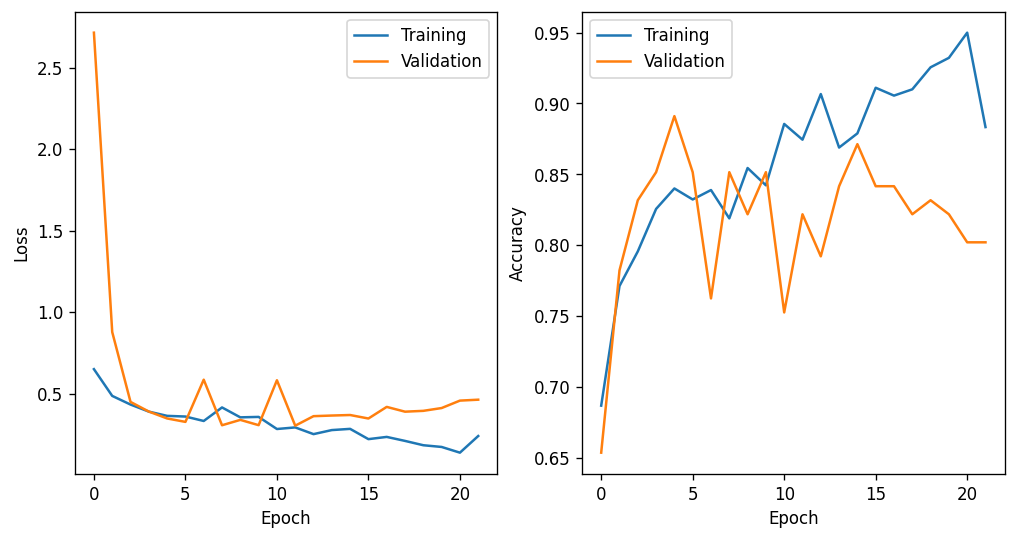

In [ ]:
plot_model_history(history)

- Now, we apply the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

#print(y_pred)
con = metrics.confusion_matrix(y_test, y_pred_labels)
print(con)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
[[172  32]
 [ 29 101]]


- To compare the performace of classifier with the random classifier, we calculate the **reciver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

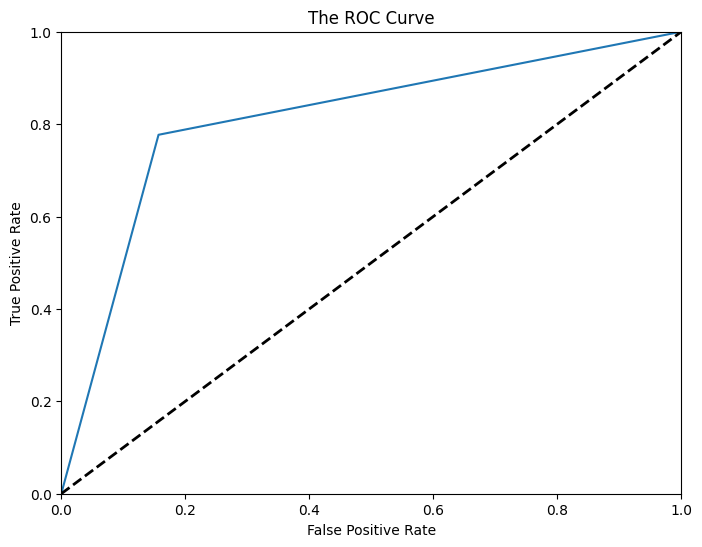

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

- To measure the performance metrics of classifier, we compute **(Recall, Precision, f1_score, Accuracy, TSS(True Skill Statistic))**

In [ ]:
#recall = recall_score(y_test, y_pred, average= 'weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted') #troubleshooting because there's a bug.....
#precision = precision_score(y_test, y_pred, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')

#f1_score = f1_score(y_test, y_pred, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')

accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.8173652694610778
Precision: 0.8182304451807864
F1_score: 0.8177304874829978
Accuracy: 0.8173652694610778
TSS: 0.6200603318250377
AUC: 0.8100301659125189


In [ ]:
# Compute test accuracy and test loss using Keras' evaluate() method
#test_loss, test_accuracy = model.evaluate(np.array(X_test), y_test, verbose=0)

# Compute training accuracy and training loss using Keras' evaluate() method
#train_loss, train_accuracy = model.evaluate(np.array(X_train), y_train, verbose=0)

# Print training vs test performance
#print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
#print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


# Trial improvement 1

Changing:

    - increasing dropout t 0.2 and 0.3 in the last dense layer.
    - adding L2 regularization kernel_regularizer=l2(0.001) - penalty for large weights. It shrinks large weights, preventing them from dominating the model.
    - using learning rate scheduler from adam optimizer for hyperparameter.
    - Increased epochs from 30 to 50 because we use regularization.

The next model that was adapted is the 1D-CNN with Zernike Moments model. SMOTE was also included in this model with a sampling strategy of 0.9. For the rest of the imbalances,, class weights were applied. The changed code now uses weight regularisation (L2 regularisation) in both the 1D Convolutional Layer as well as Dense layers. This should help reduce overfitting by penalising the large weight values. In addition to this, a directout was added for better generalisations. The original code uses dropout of 0.1 across layers, code 2 increases the dropout to 0.2 in the convolutional layers and to 0.3 in the final layers. This should improve regularisation. Furthermore a Learning rate scheduler was implemented. The code uses a fixed Adam optimizer with default learning rate. Now the updated code is using a learning rate that lowers if the validation loss stops improving. This should prevent getting stuck in a local minima and should result in faster convergence. On top of that, the epochs were increased from 30 to 50 as the dropout is increased and regularisation is applied, thus using longer learning to balance.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


galaxies_labels = np.zeros(len(zmg))
nongalaxy_labels = np.ones(len(zmng))
all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])
len(all_labels)

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)  # Ensure SMOTE is applied correctly


class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

# Input layer
x = Input(shape=(all_zm_data.shape[1],1))

# Convolutional layers with regularization
c0 = Conv1D(256, kernel_size=3, strides=2, padding="same", kernel_regularizer=l2(0.001))(x) # adding kernal regularizer
b0 = BatchNormalization()(c0)
m0 = MaxPooling1D(pool_size=2)(b0)
d0 = Dropout(0.2)(m0)

c1 = Conv1D(128, kernel_size=3, strides=2, padding="same", kernel_regularizer=l2(0.001))(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling1D(pool_size=2)(b1)
d1 = Dropout(0.2)(m1)

c2 = Conv1D(64, kernel_size=3, strides=2, padding="same", kernel_regularizer=l2(0.001))(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling1D(pool_size=2)(b2)
d2 = Dropout(0.3)(m2)


f = Flatten()(d2)

#output
de0 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(f)
de1 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(de0)
de2 = Dense(2, activation='softmax')(de1)

# Model compilation
model = Model(inputs=x, outputs=de2, name="cnn_galaxy_nonegalaxy")
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.001)  # Use learning rate scheduler later

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

# Early stopping and learning rate reduction
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Training parameters
b_size = 64
e_num = 50  # Increase epochs since we use regularization

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=b_size,
    epochs=e_num,
    class_weight=class_weights,
    validation_split=0.1,
    verbose=1,
    callbacks=[es, lr_scheduler]
)


Model: "cnn_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_57 (Conv1D)                   │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_57 (MaxPooling1D)      │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_58 (Conv1D)                   │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_58 (MaxPooling1D)      │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_59 (MaxPooling1D)      │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,730 (772.38 KB)

 Trainable params: 196,834 (768.88 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 535ms/step - accuracy: 0.6610 - loss: 1.0348 - val_accuracy: 0.8850 - val_loss: 1.2227 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7592 - loss: 0.9181 - val_accuracy: 0.7876 - val_loss: 1.6027 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8007 - loss: 0.8552 - val_accuracy: 0.9027 - val_loss: 0.6759 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7702 - loss: 0.8464 - val_accuracy: 0.6991 - val_loss: 1.3564 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8146 - loss: 0.8180 - val_accuracy: 0.8407 - val_loss: 0.7361 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8212 - loss: 0.8127
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8212 - loss: 0.8122 - val_ac

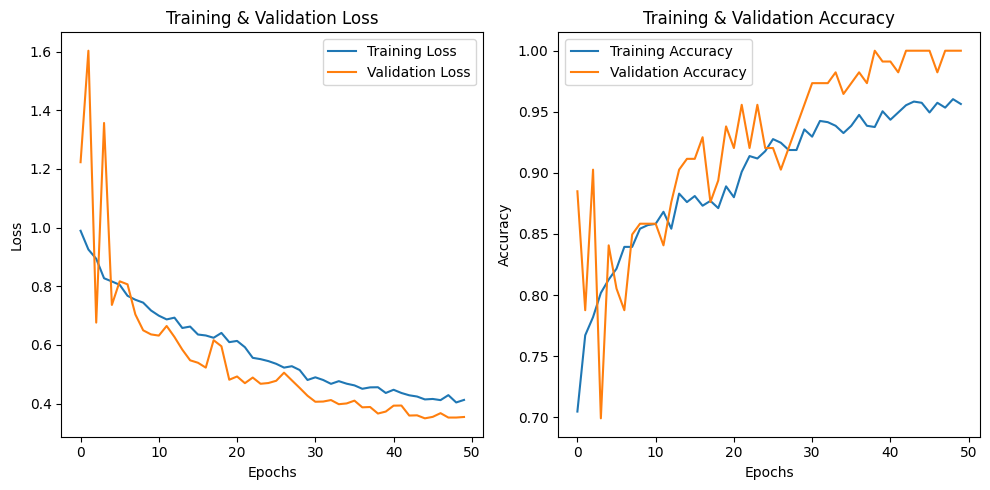

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.4123131036758423
Final Training Accuracy: 0.9563924670219421
Final Validation Loss: 0.35413995385169983
Final Validation Accuracy: 1.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


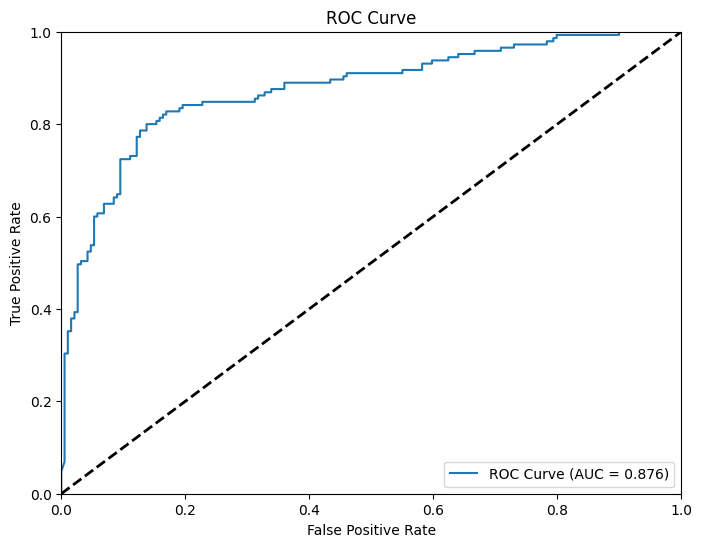

In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Compute AUC
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Class names for the labels
class_names = ['Galaxy', 'None-Galaxy']

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

# Plot diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Show plot
plt.legend(loc="lower right")
plt.show()


# Evaluate Test Set
#test_loss, test_acc = model.evaluate(np.array(transformed_X_test), to_categorical(y_test, num_classes=2))
#print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


In [ ]:
# Compute test accuracy and test loss using Keras' evaluate() method
test_loss, test_accuracy = model.evaluate(np.array(X_test), y_test, verbose=0)

# Compute training accuracy and training loss using Keras' evaluate() method
train_loss, train_accuracy = model.evaluate(np.array(X_train), y_train, verbose=0)

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 0.358, Training Accuracy: 0.992
Test Loss: 0.847, Test Accuracy: 0.832


In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.781437125748503
Precision: 0.783894025403856
F1_score: 0.7820976522818124
Accuracy: 0.781437125748503
TSS: 0.5619883040935673
AUC: 0.8757343550446999
